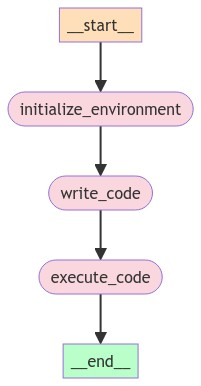

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List

from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, AIMessage, SystemMessage
from langchain_experimental.utilities import PythonREPL
from langchain.output_parsers import RegexParser
from typing import Literal
from IPython.display import Image, display
import requests

# Define the state to hold the code and execution output
class CodeState(TypedDict):
    messages: list
    start_url: str
    imports: list
    code: list
    output: str
    env_id: str

def initialize_environment(state):
    # Execute the code and capture output
    print("initialize_environment start")

    code = """from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions

options = ChromeOptions()

driver = webdriver.Remote('http://selenium:4444/wd/hub', options=options)
    """

    print("Init")
    response = requests.post("http://localhost:8085/setup")
    env_id = response.json()["env_id"]

    print("Run code")
    payload = {"env_id": env_id, "code": code}
    print(payload)
    response = requests.post("http://localhost:8085/execute", json=payload)
    print("Ran", response)
    output = response.json()

    print("Output:", output)
    
    print("initialize_environment end")
    return {"code": code, "env_id": env_id}

# Function to write code using an LLM
def write_code(state):
    print("write_code start")
    llm = Ollama(model='llama3')

    code_parser = RegexParser(
        regex=r"```((.|\n)*)```",
        output_keys=["code"],
        default_output_key="code"
    )

    prompt = PromptTemplate(
        input_variables=["url"],
        template="""In Python using Selenium, write code code to navigate to the URL given below.  Omit all import statements from your code.  Output one and no more than one code block.

In the environment you are creating code in, you already have a Selenium webdriver available and instantiated in the variable named `driver`.

After navigating to the URL, sleep for 20 seconds before ending the session.

URL: {url}
"""
    )

    start_url = state['start_url']
    response = llm.predict(prompt.format(url=start_url))
    print(type(response))
    print("full response[[[", response, "]]]")
    response = code_parser.parse(response)
    print(response)
    response = response['code'].strip()
    print("parsed response[[[", response, "]]]")
    state['messages'].append(AIMessage(content=response))

    print("write_code end")
    return {'code': response}

def execute_code(state):
    print("execute_code start")
    payload = {"env_id": state["env_id"], "code": state["code"]}
    response = requests.post("http://localhost:8085/execute", json=payload)
    output = response.json()

    print(output)
    print("execute_code end")

# Create the LangGraph
graph = StateGraph(CodeState)
graph.add_node("initialize_environment", initialize_environment)
graph.add_node("write_code", write_code)
graph.add_node("execute_code", execute_code)

graph.add_edge("initialize_environment", "write_code")
graph.add_edge("write_code", "execute_code")
graph.add_edge("execute_code", END)


graph.set_entry_point("initialize_environment")

runnable = graph.compile()

display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))


In [2]:
inputs = {'start_url': "http://www.amazon.com", "messages": []}
#inputs = {'messages': [HumanMessage("Hi how are you")]}

seen_messages = set()

for event in runnable.stream(inputs, stream_mode="values"):
    for message in event['messages']:
        if isinstance(message, HumanMessage):
            message_id = id(message)
            if message_id not in seen_messages:
                print(f"Human: {message.content}")
                seen_messages.add(message_id)
        elif isinstance(message, AIMessage):
            message_id = id(message)
            if message_id not in seen_messages:
                print(f"Assistant: {message.content}")
                seen_messages.add(message_id)

initialize_environment start
Init
Run code
{'env_id': '6c99bb34-480c-438b-9828-4dd25011a008', 'code': "from selenium import webdriver\nfrom selenium.webdriver.chrome.options import Options as ChromeOptions\n\noptions = ChromeOptions()\n\ndriver = webdriver.Remote('http://selenium:4444/wd/hub', options=options)\n    "}
Ran <Response [200]>
Output: {'output': ''}
initialize_environment end
write_code start


/Users/corymills/Develop/llm-actions/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


<class 'str'>
full response[[[ ```
driver.get("http://www.amazon.com")
time.sleep(20)
``` ]]]
{'code': '\ndriver.get("http://www.amazon.com")\ntime.sleep(20)\n'}
parsed response[[[ driver.get("http://www.amazon.com")
time.sleep(20) ]]]
write_code end
Assistant: driver.get("http://www.amazon.com")
time.sleep(20)
execute_code start
{'error': "name 'time' is not defined"}
execute_code end


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
import time

options = ChromeOptions()

driver = webdriver.Remote('http://localhost:4444/wd/hub', options=options)

driver.get("https://www.google.com")
print("Page title: " + driver.title)

time.sleep(20)

driver.quit()